<a href="https://colab.research.google.com/github/Syed-Osama-Hussain/Imagined-Speech-Prediction-from-EEG/blob/master/long_short_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.io
import os
from google.colab import drive
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.utils import shuffle
from keras.layers import LSTM, Dropout, GRU, Input, Reshape
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers.merge import concatenate
from keras.models import Model
import keras.backend as K
from tensorflow.keras.optimizers import Adam

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls "drive/My Drive/dataset/Short_Long_words/"

sub_10_ch64_sl_eog_removed_256Hz_bw20.mat
sub_14_ch64_sl_eog_removed_256Hz_bw20.mat
sub_1c_ch64_sl_eog_removed_256Hz_bw20.mat
sub_5c_ch64_sl_eog_removed_256Hz_bw20.mat
sub_8d_ch64_sl_eog_removed_256Hz.mat
sub_9b_ch64_sl_eog_removed_256Hz_bw20.mat


In [ ]:
mat = scipy.io.loadmat("drive/My Drive/dataset/Short_Long_words/sub_8d_ch64_sl_eog_removed_256Hz")
end_trial = mat['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
last_beep = mat['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']

Cooperate during speech imagery state

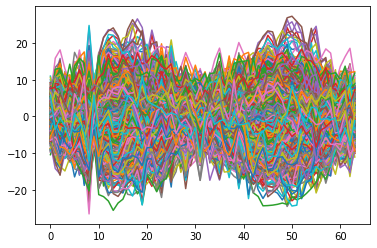

In [ ]:
plt.plot(last_beep[0][0]);

"In" during Speech Imagery

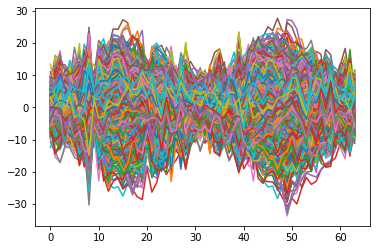

In [ ]:
plt.plot(last_beep[1][0]);

C1 = Cooperate, C2 = In

In [4]:
def covariance(matrix):
  res_mat = np.cov(matrix,bias=True)
  return res_mat

In [ ]:
def loadMatrices(dir):
  matrices_c1 = []
  matrices_c2 = []
  for root,sub,files in os.walk(dir):
    for f in sorted(files):
      mat_file  =  scipy.io.loadmat(os.path.join(root, f))
      end_trial = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
      last_beep = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
      matrices_c1.extend([covariance(matrix) for matrix in end_trial[0]])
      matrices_c1.extend([covariance(matrix) for matrix in last_beep[0]])
      matrices_c2.extend([covariance(matrix) for matrix in end_trial[1]])
      matrices_c2.extend([covariance(matrix) for matrix in last_beep[1]])
  return np.concatenate((np.array(matrices_c1),np.array(matrices_c2)),axis=0)

In [5]:
def loadMatricesLongShort(dir):
  matrices_c1 = []
  matrices_c2 = []
  for root,sub,files in os.walk(dir):
    for f in sorted(files):
      mat_file  =  scipy.io.loadmat(os.path.join(root, f))
      end_trial = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
      last_beep = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
      matrices_c1.extend([covariance(matrix) for matrix in end_trial[0]])
      matrices_c1.extend([covariance(matrix) for matrix in last_beep[0]])
      matrices_c2.extend([covariance(matrix) for matrix in end_trial[1]])
      matrices_c2.extend([covariance(matrix) for matrix in last_beep[1]])
  return matrices_c1,matrices_c2

In [7]:
def loadMatricesLong(dir):
  matrices_c1 = []
  for root,sub,files in os.walk(dir):
    for f in sorted(files):
      mat_file  =  scipy.io.loadmat(os.path.join(root, f))
      end_trial = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
      last_beep = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
      matrices_c1.extend([covariance(matrix) for matrix in end_trial[0]])
      matrices_c1.extend([covariance(matrix) for matrix in last_beep[0]])
  return matrices_c1

In [8]:
def loadMatricesShort(dir):
  matrices_c2 = []
  for root,sub,files in os.walk(dir):
    for f in sorted(files):
      mat_file  =  scipy.io.loadmat(os.path.join(root, f))
      end_trial = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
      last_beep = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
      matrices_c2.extend([covariance(matrix) for matrix in end_trial[1]])
      matrices_c2.extend([covariance(matrix) for matrix in last_beep[1]])
  return matrices_c2

In [9]:
def loadMatricesAll():
  c1 = []
  c2 = []
  c1,c2 = loadMatricesLongShort("drive/My Drive/dataset/Short_Long_words/")
  c1.extend(loadMatricesLong("drive/My Drive/dataset/Long_words/"))
  c2.extend(loadMatricesShort("drive/My Drive/dataset/Short_words/"))
  return np.concatenate((np.array(c1),np.array(c2)),axis=0)

In [10]:
train_data = loadMatricesAll()

In [11]:
print(train_data.shape)

(4240, 64, 64)


In [12]:
labels = np.concatenate((np.zeros(2120),np.ones(2120)),axis=0)
print(labels)

[0. 0. 0. ... 1. 1. 1.]


In [13]:
from keras.utils.np_utils import to_categorical
labels = to_categorical(labels, num_classes=2)
print(labels.shape,labels)

(4240, 2) [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [14]:
visible = Input(shape=(64,64))
#CNN
cov1 = Conv1D(filters=64, kernel_size=2, activation="relu")(visible)
cov2 = Conv1D(filters=64, kernel_size=4, activation="relu")(cov1)
newShape = Reshape((60,64), name='newReshape')(cov2)
f1 = Flatten()(newShape)
d1 = Dense(128, activation='relu')(f1)
d2 = Dense(128, activation='relu')(d1)

#RNN
gru1 = GRU(64,activation="relu",return_sequences=True)(visible)
gru2 = GRU(64,activation="relu")(gru1)
d3 = Dense(64, activation='relu')(gru2)
d4 = Dense(64, activation='relu')(d3)
#Merge
merge = concatenate([d2, d4])

#DAE
encoder1 = Dense(768, activation='relu')(merge)
encoder2 = Dense(96, activation='relu')(encoder1)
decoder1 = Dense(768, activation='relu')(encoder2)
decoder2 = Dense(192, activation='relu')(decoder1)

#FNN
hidden1 = Dense(64, activation='relu')(encoder2)
hidden2 = Dense(64, activation='relu')(hidden1)
output = Dense(2, activation='softmax')(hidden2)
model = Model(inputs=visible, outputs=output)
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 63, 64)       8256        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 60, 64)       16448       conv1d[0][0]                     
__________________________________________________________________________________________________
newReshape (Reshape)            (None, 60, 64)       0           conv1d_1[0][0]                   
_______________________________________________________________________________________

In [15]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
train_data, labels = shuffle(train_data, labels)

Iteration no  0  for training 
Epoch 1/100
106/106 [==============================] - 7s 62ms/step - loss: 0.7109 - accuracy: 0.6492 - val_loss: 0.6643 - val_accuracy: 0.7252
Epoch 2/100
106/106 [==============================] - 6s 60ms/step - loss: 0.5628 - accuracy: 0.7146 - val_loss: 0.5724 - val_accuracy: 0.7252
Epoch 3/100
106/106 [==============================] - 6s 59ms/step - loss: 0.5082 - accuracy: 0.7417 - val_loss: 0.5357 - val_accuracy: 0.7535
Epoch 4/100
106/106 [==============================] - 6s 59ms/step - loss: 0.6087 - accuracy: 0.7064 - val_loss: 0.5321 - val_accuracy: 0.7347
Epoch 5/100
106/106 [==============================] - 7s 70ms/step - loss: 0.4726 - accuracy: 0.7506 - val_loss: 0.5209 - val_accuracy: 0.7170
Epoch 6/100
106/106 [==============================] - 6s 59ms/step - loss: 0.4497 - accuracy: 0.7479 - val_loss: 0.6646 - val_accuracy: 0.7111
Epoch 7/100
106/106 [==============================] - 6s 59ms/step - loss: 0.4247 - accuracy: 0.7692 - v

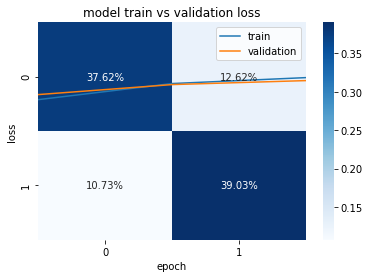

Iteration no  1  for training 
Epoch 1/100
106/106 [==============================] - 6s 60ms/step - loss: 0.3505 - accuracy: 0.8726 - val_loss: 0.2477 - val_accuracy: 0.9033
Epoch 2/100
106/106 [==============================] - 6s 59ms/step - loss: 0.1902 - accuracy: 0.9331 - val_loss: 0.2437 - val_accuracy: 0.9222
Epoch 3/100
106/106 [==============================] - 6s 60ms/step - loss: 0.1641 - accuracy: 0.9455 - val_loss: 0.4382 - val_accuracy: 0.9068
Epoch 4/100
106/106 [==============================] - 6s 59ms/step - loss: 0.2065 - accuracy: 0.9422 - val_loss: 0.2639 - val_accuracy: 0.9139
Epoch 5/100
106/106 [==============================] - 6s 59ms/step - loss: 0.1312 - accuracy: 0.9581 - val_loss: 0.2512 - val_accuracy: 0.9080
Epoch 6/100
106/106 [==============================] - 6s 59ms/step - loss: 0.1074 - accuracy: 0.9596 - val_loss: 0.2681 - val_accuracy: 0.9139
Epoch 7/100
106/106 [==============================] - 6s 58ms/step - loss: 0.1042 - accuracy: 0.9634 - v

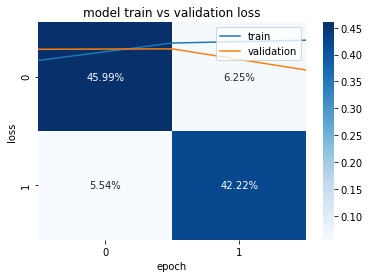

Iteration no  2  for training 
Epoch 1/100
106/106 [==============================] - 6s 60ms/step - loss: 0.3179 - accuracy: 0.8936 - val_loss: 0.1464 - val_accuracy: 0.9540
Epoch 2/100
106/106 [==============================] - 6s 59ms/step - loss: 0.1713 - accuracy: 0.9378 - val_loss: 0.2333 - val_accuracy: 0.9399
Epoch 3/100
106/106 [==============================] - 6s 59ms/step - loss: 0.1008 - accuracy: 0.9667 - val_loss: 0.1853 - val_accuracy: 0.9446
Epoch 4/100
106/106 [==============================] - 6s 60ms/step - loss: 0.0983 - accuracy: 0.9705 - val_loss: 0.1778 - val_accuracy: 0.9623
Epoch 5/100
106/106 [==============================] - 6s 60ms/step - loss: 0.0688 - accuracy: 0.9752 - val_loss: 0.1918 - val_accuracy: 0.9399
Epoch 6/100
106/106 [==============================] - 6s 60ms/step - loss: 0.0532 - accuracy: 0.9817 - val_loss: 0.1734 - val_accuracy: 0.9552
Epoch 7/100
106/106 [==============================] - 6s 60ms/step - loss: 0.0433 - accuracy: 0.9856 - v

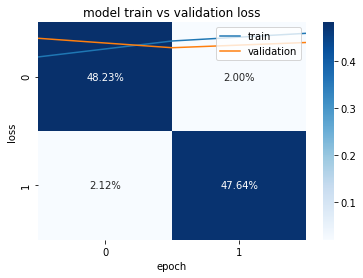

Iteration no  3  for training 
Epoch 1/100
106/106 [==============================] - 6s 60ms/step - loss: 0.4284 - accuracy: 0.7978 - val_loss: 0.4289 - val_accuracy: 0.7983
Epoch 2/100
106/106 [==============================] - 6s 60ms/step - loss: 0.3220 - accuracy: 0.8511 - val_loss: 0.3285 - val_accuracy: 0.8314
Epoch 3/100
106/106 [==============================] - 6s 60ms/step - loss: 0.2344 - accuracy: 0.9062 - val_loss: 0.2315 - val_accuracy: 0.9092
Epoch 4/100
106/106 [==============================] - 6s 59ms/step - loss: 0.1522 - accuracy: 0.9416 - val_loss: 0.2394 - val_accuracy: 0.9139
Epoch 5/100
106/106 [==============================] - 6s 59ms/step - loss: 0.1165 - accuracy: 0.9540 - val_loss: 0.2245 - val_accuracy: 0.9257
Epoch 6/100
106/106 [==============================] - 6s 60ms/step - loss: 0.0882 - accuracy: 0.9693 - val_loss: 0.2014 - val_accuracy: 0.9304
Epoch 7/100
106/106 [==============================] - 6s 60ms/step - loss: 0.1300 - accuracy: 0.9629 - v

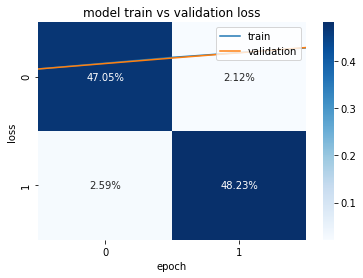

Iteration no  4  for training 
Epoch 1/100
106/106 [==============================] - 6s 59ms/step - loss: 0.3485 - accuracy: 0.9036 - val_loss: 0.1878 - val_accuracy: 0.9186
Epoch 2/100
106/106 [==============================] - 6s 59ms/step - loss: 0.1465 - accuracy: 0.9425 - val_loss: 0.1059 - val_accuracy: 0.9564
Epoch 3/100
106/106 [==============================] - 6s 60ms/step - loss: 0.0638 - accuracy: 0.9773 - val_loss: 0.0892 - val_accuracy: 0.9764
Epoch 4/100
106/106 [==============================] - 6s 60ms/step - loss: 0.0478 - accuracy: 0.9841 - val_loss: 0.1291 - val_accuracy: 0.9564
Epoch 5/100
106/106 [==============================] - 6s 61ms/step - loss: 0.0411 - accuracy: 0.9823 - val_loss: 0.0817 - val_accuracy: 0.9752
Epoch 6/100
106/106 [==============================] - 6s 60ms/step - loss: 0.0323 - accuracy: 0.9882 - val_loss: 0.0817 - val_accuracy: 0.9717
Epoch 7/100
106/106 [==============================] - 6s 60ms/step - loss: 0.0236 - accuracy: 0.9915 - v

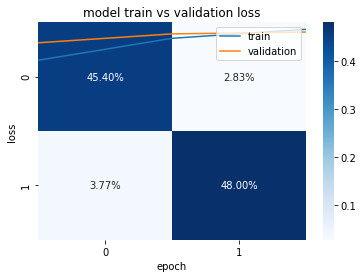

In [17]:
for i in range(5):
  print("Iteration no ",i," for training \n=========\n=========\n=========")

  train_data, labels = shuffle(train_data, labels)

  divide_percent=(len(train_data)*0.2)
  x_test=train_data[0:int(divide_percent)]
  y_test=labels[0:int(divide_percent)]
  x_train = train_data[int(divide_percent):len(train_data)]
  y_train = labels[int(divide_percent):len(labels)]
  history = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,verbose=1)
  predictions = model.predict(x_test,verbose=0)
  np.round(predictions)
  rounded_labels = np.argmax(y_test, axis=1)
  rounded_predictions = np.argmax(predictions, axis=1)
  cf = confusion_matrix(rounded_labels,rounded_predictions)  # doctest: +SKIP
  sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')
  print("Loss Comparison ====================================================")
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

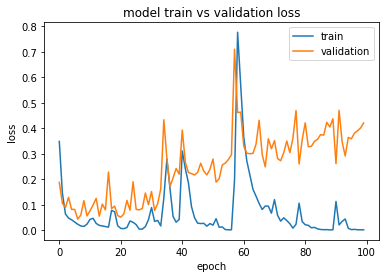

In [18]:
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

#Max Accuracy 
loss: 0.0017 - accuracy: 0.9994 - val_loss: 0.4209 - val_accuracy: 0.9340

In [19]:
model.save("model_long_short_words.h5")